# Lab Assignment Seven: Recurrent Network Architectures

*Yiwen Xu, Kehan Zhang, Shuang Liang, Christopher Deng Jr*

## 1 Preparation 

### 1.1 Load Data

In this project, we built a model that can classify subreddits of mental disorders as BPD (borderline personality disorder), anxiety, and other by training with 10500 lines of text.

The data set we used for training and testing was from:
[Mental Disorders Identification (Reddit)](https://www.kaggle.com/datasets/kamaruladha/mental-disorders-identification-reddit-nlp), which contains 700k rows of text retrieved from multiple subreddits related to mental disorders.


In [1]:
import pandas as pd
import numpy as np
import missingno as mn
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('mental_disorders_reddit.csv')

df.head()

,title,selftext,created_utc,over_18,subreddit
0,Life is so pointless without others,Does anyone else think the most important part...,1650356960,False,BPD
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,False,BPD
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,False,BPD
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,False,BPD
4,help,[removed],1650350907,False,BPD


In [3]:
df.dtypes

title          object
selftext       object
created_utc     int64
over_18          bool
subreddit      object
dtype: object

In [4]:
# Remove the special flag in the selftext column that also indicates NaN
def remove_flag(text):
    if text == '[removed]'or text == '[deleted]':
        return None
    return text

df['selftext'] = df['selftext'].apply(remove_flag)


### 1.2 Data Preprocessing

In [5]:
print(df.shape)

(701787, 5)


In [6]:
df.isnull().sum()

title              46
selftext       130308
created_utc         0
over_18             0
subreddit           0
dtype: int64

<AxesSubplot:>

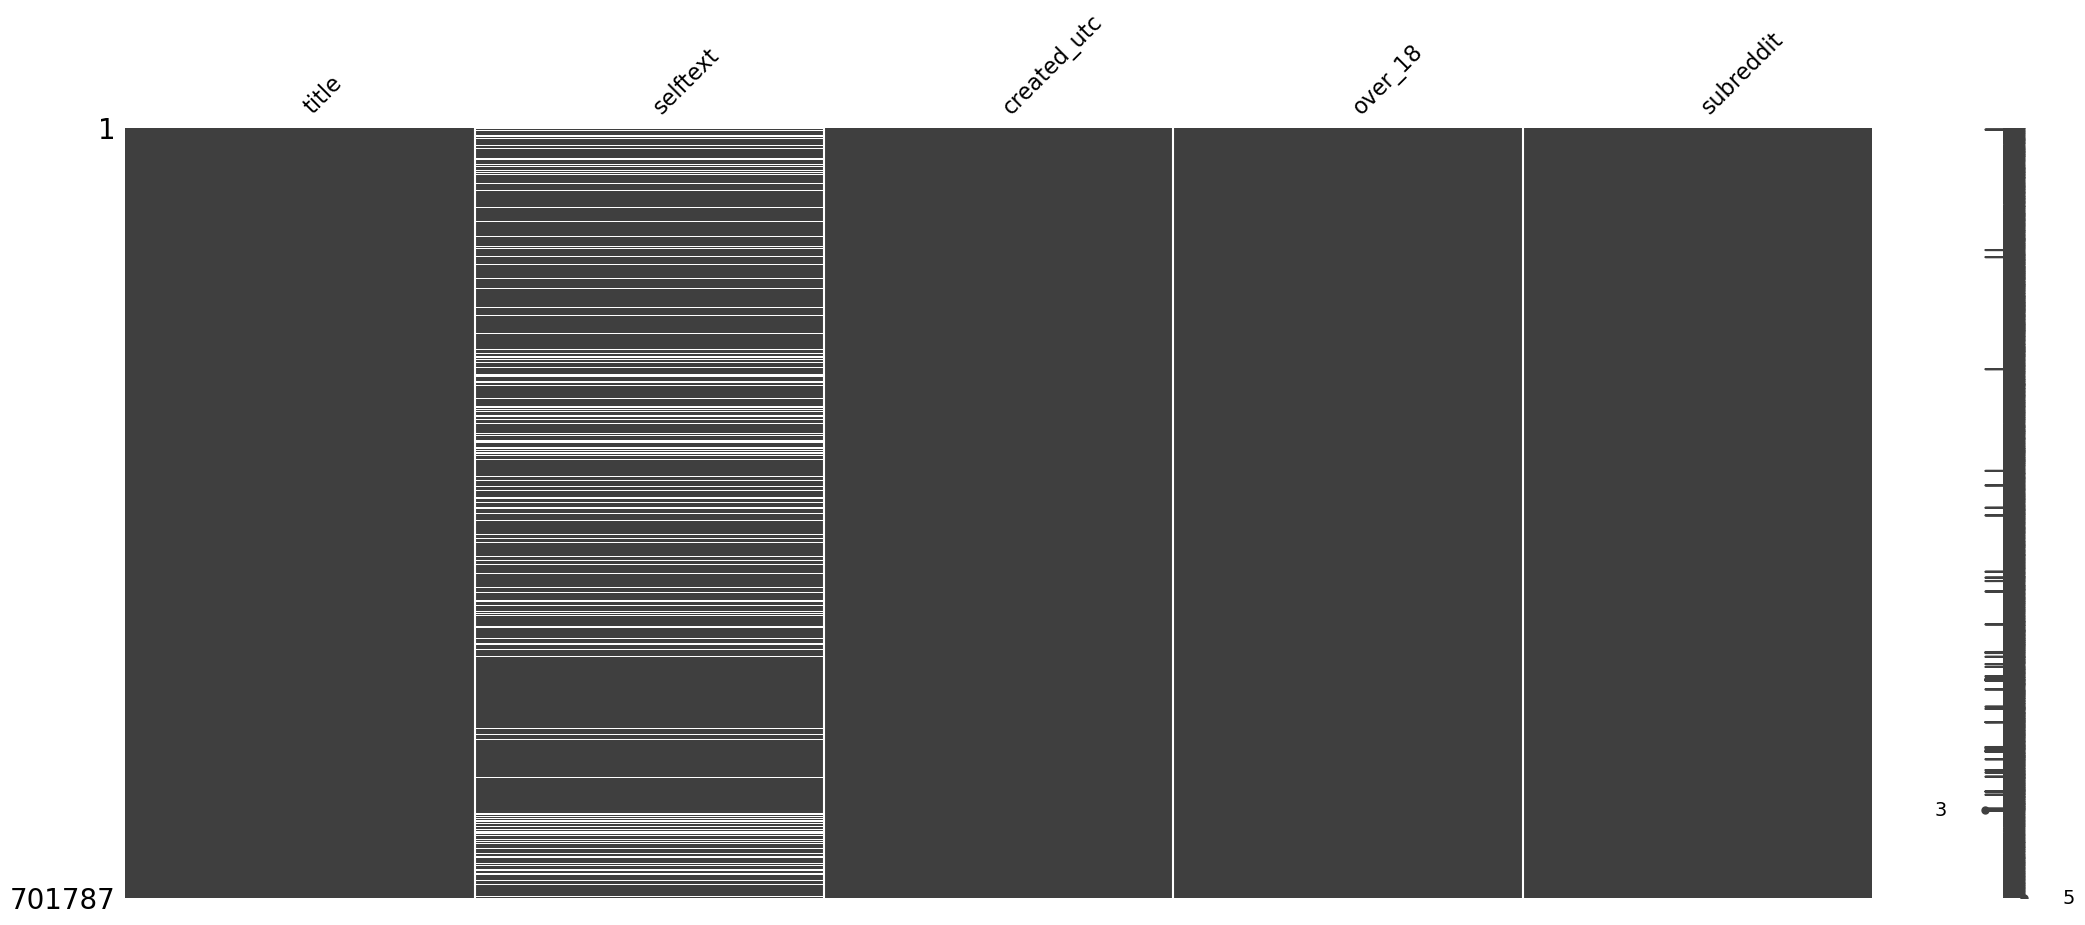

In [7]:
mn.matrix(df)

In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

title          0
selftext       0
created_utc    0
over_18        0
subreddit      0
dtype: int64

<AxesSubplot:>

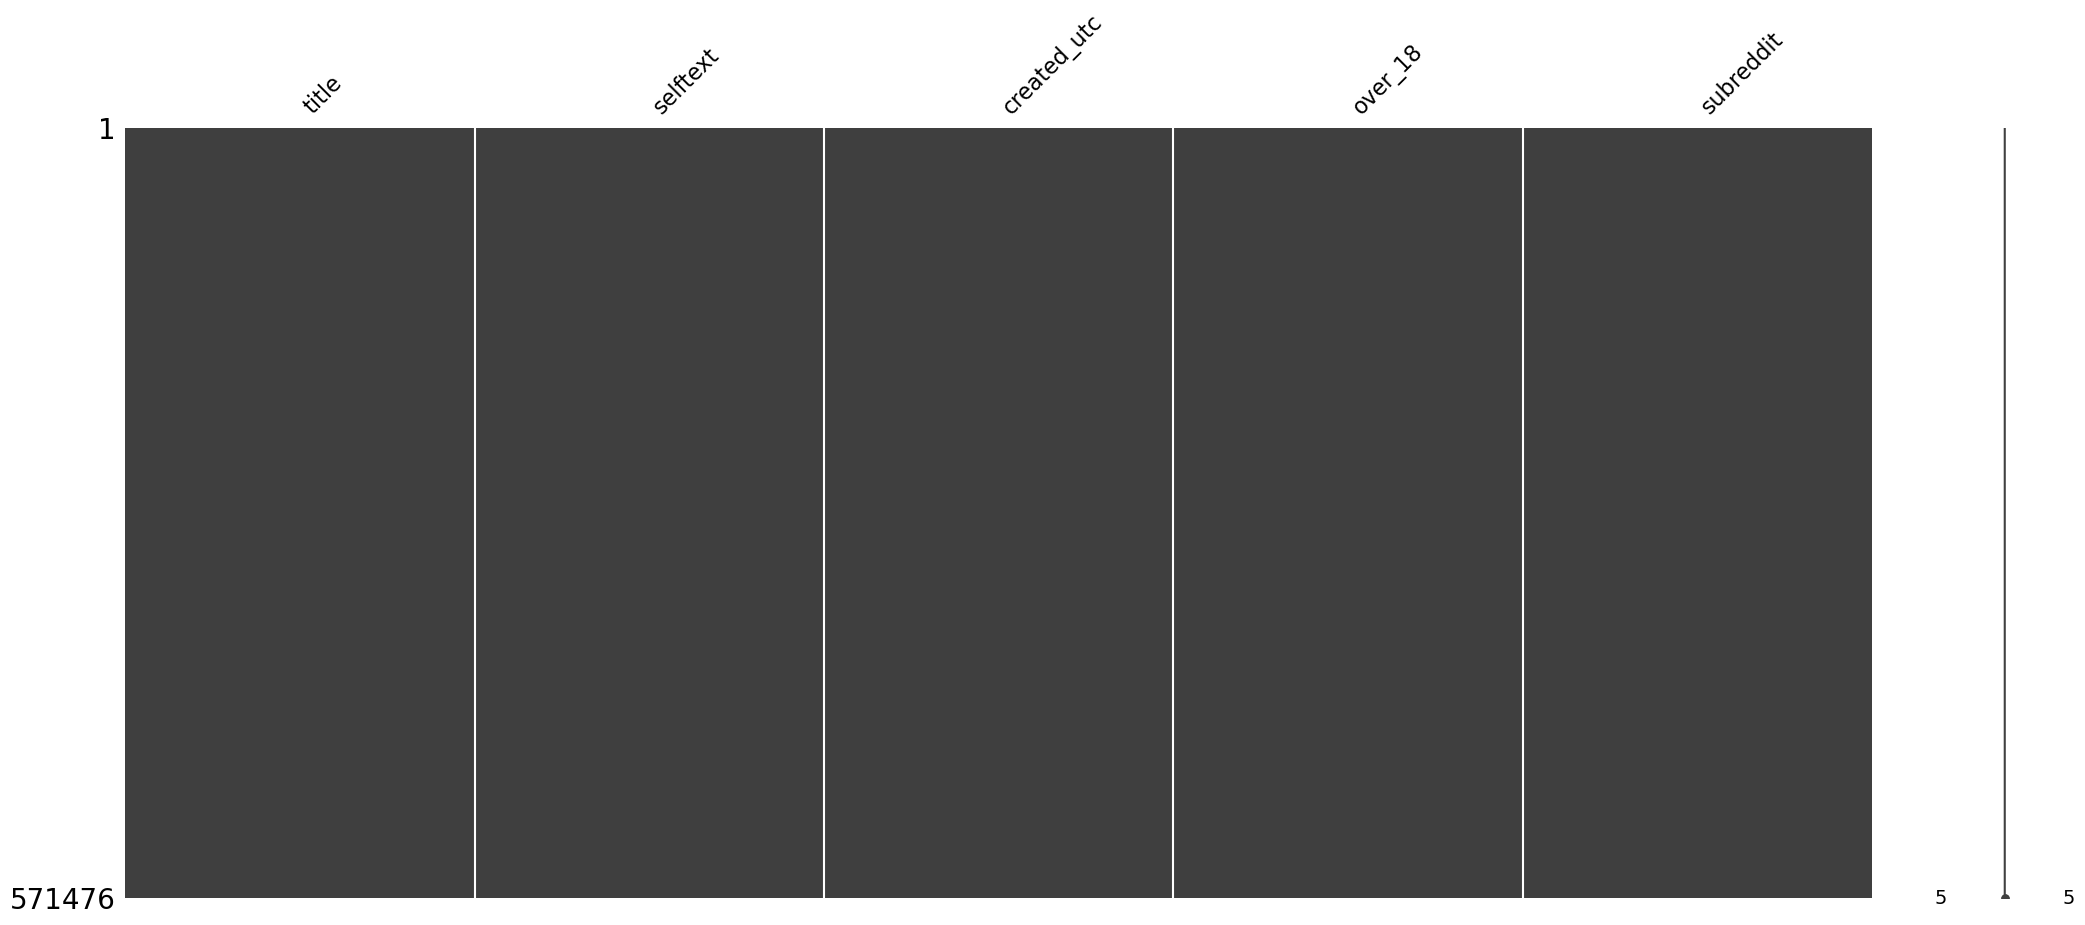

In [10]:
mn.matrix(df)

Check if there's any empty or missing data entries.

In [11]:
df['text_total'] = df['selftext'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

df['text_chars'] = df["selftext"].apply(count_total_words)

Add columns for the number of word and char of 'selftext' by 'subreddit'.

In [12]:
df.head()

,title,selftext,created_utc,over_18,subreddit,text_total,text_chars
0,Life is so pointless without others,Does anyone else think the most important part...,1650356960,False,BPD,74,310
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,False,BPD,517,2259
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,False,BPD,145,545
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,False,BPD,821,3282
5,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",1650350635,False,BPD,202,913


In [13]:
df_na = df[df['text_chars'].apply(lambda x:x<=0)]
df_na.head()

,title,selftext,created_utc,over_18,subreddit,text_total,text_chars
161908,What does BPD look like in someone who has no ...,,1548970690,False,BPD,0,0
170275,As the nonBPD recipient of a relationship ende...,\n\n,1551630010,False,BPD,0,0
170555,Anyone have a FP that they haven’t met in person?,\n,1552956926,False,BPD,0,0
184421,Omg. So I'm 15 f a student and I know a m bord...,\n,1552756396,False,BPD,0,0
189724,Bpd and npd in a relationship?,\n\n\n,1533471283,False,BPD,0,0


In [14]:
df = df[df['text_chars'].apply(lambda x:x > 0)]

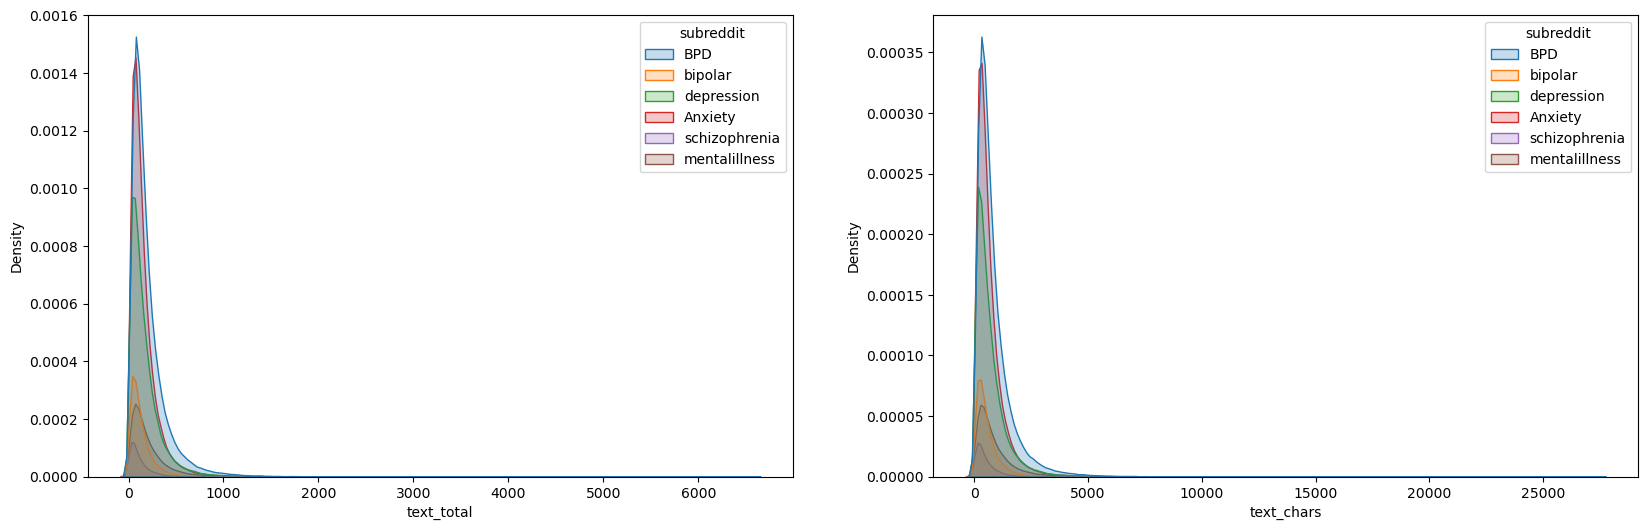

In [15]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(x = df['text_total'], hue= df['subreddit'], shade = True)

plt.subplot(1, 2, 2)
sns.kdeplot(x = df['text_chars'], hue= df['subreddit'], shade = True)

plt.show()

Based on the KDE graph shown above, we can see that the probability density of having a large number of words in an entity is very low. Therefore, we want to cut down those entities that contain a large number of words to keep our model trained with a reasonable running time.

In [16]:
df['text_chars'].quantile(q = 0.90)

1558.0

In [17]:
df = df[df['text_total'].apply(lambda x:x<=1500)]


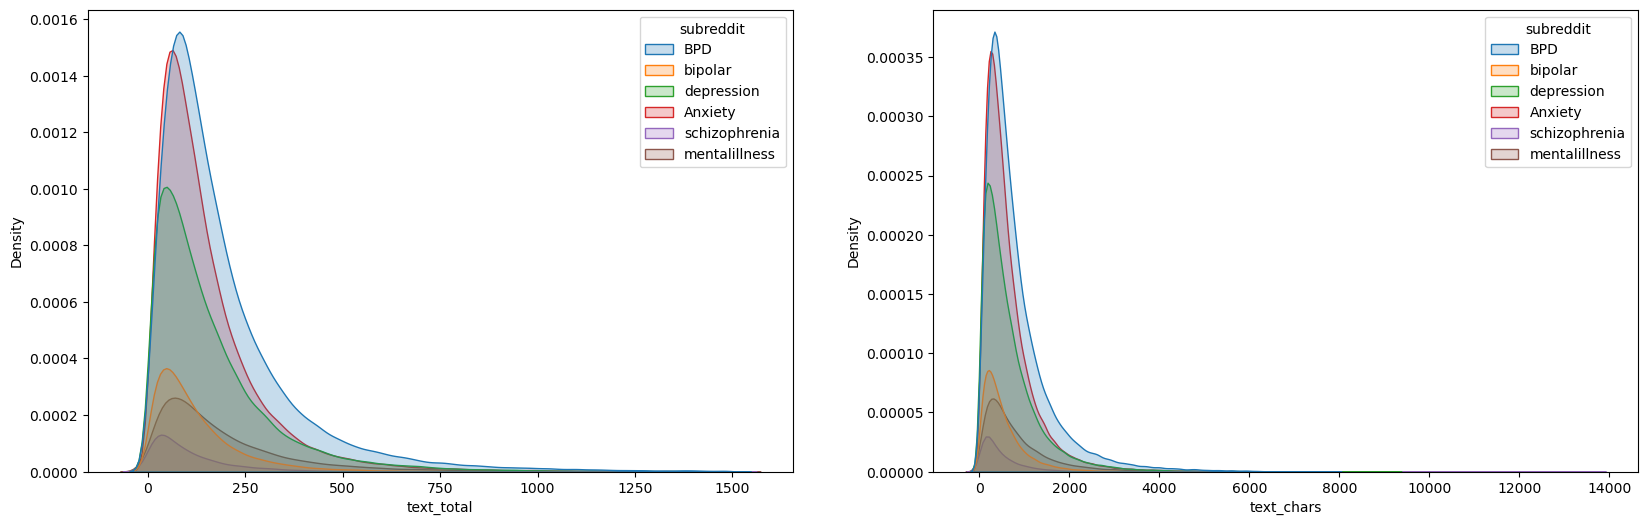

In [18]:
plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(x = df['text_total'], hue= df['subreddit'], shade = True)

plt.subplot(1, 2, 2)
sns.kdeplot(x = df['text_chars'], hue= df['subreddit'], shade = True)

plt.show()

KDE plots of the number of word and char of 'selftext' by 'subreddit'.

In [19]:
df['subreddit'].value_counts()

BPD              204395
Anxiety          160375
depression       120777
mentalillness     37257
bipolar           35581
schizophrenia     11681
Name: subreddit, dtype: int64

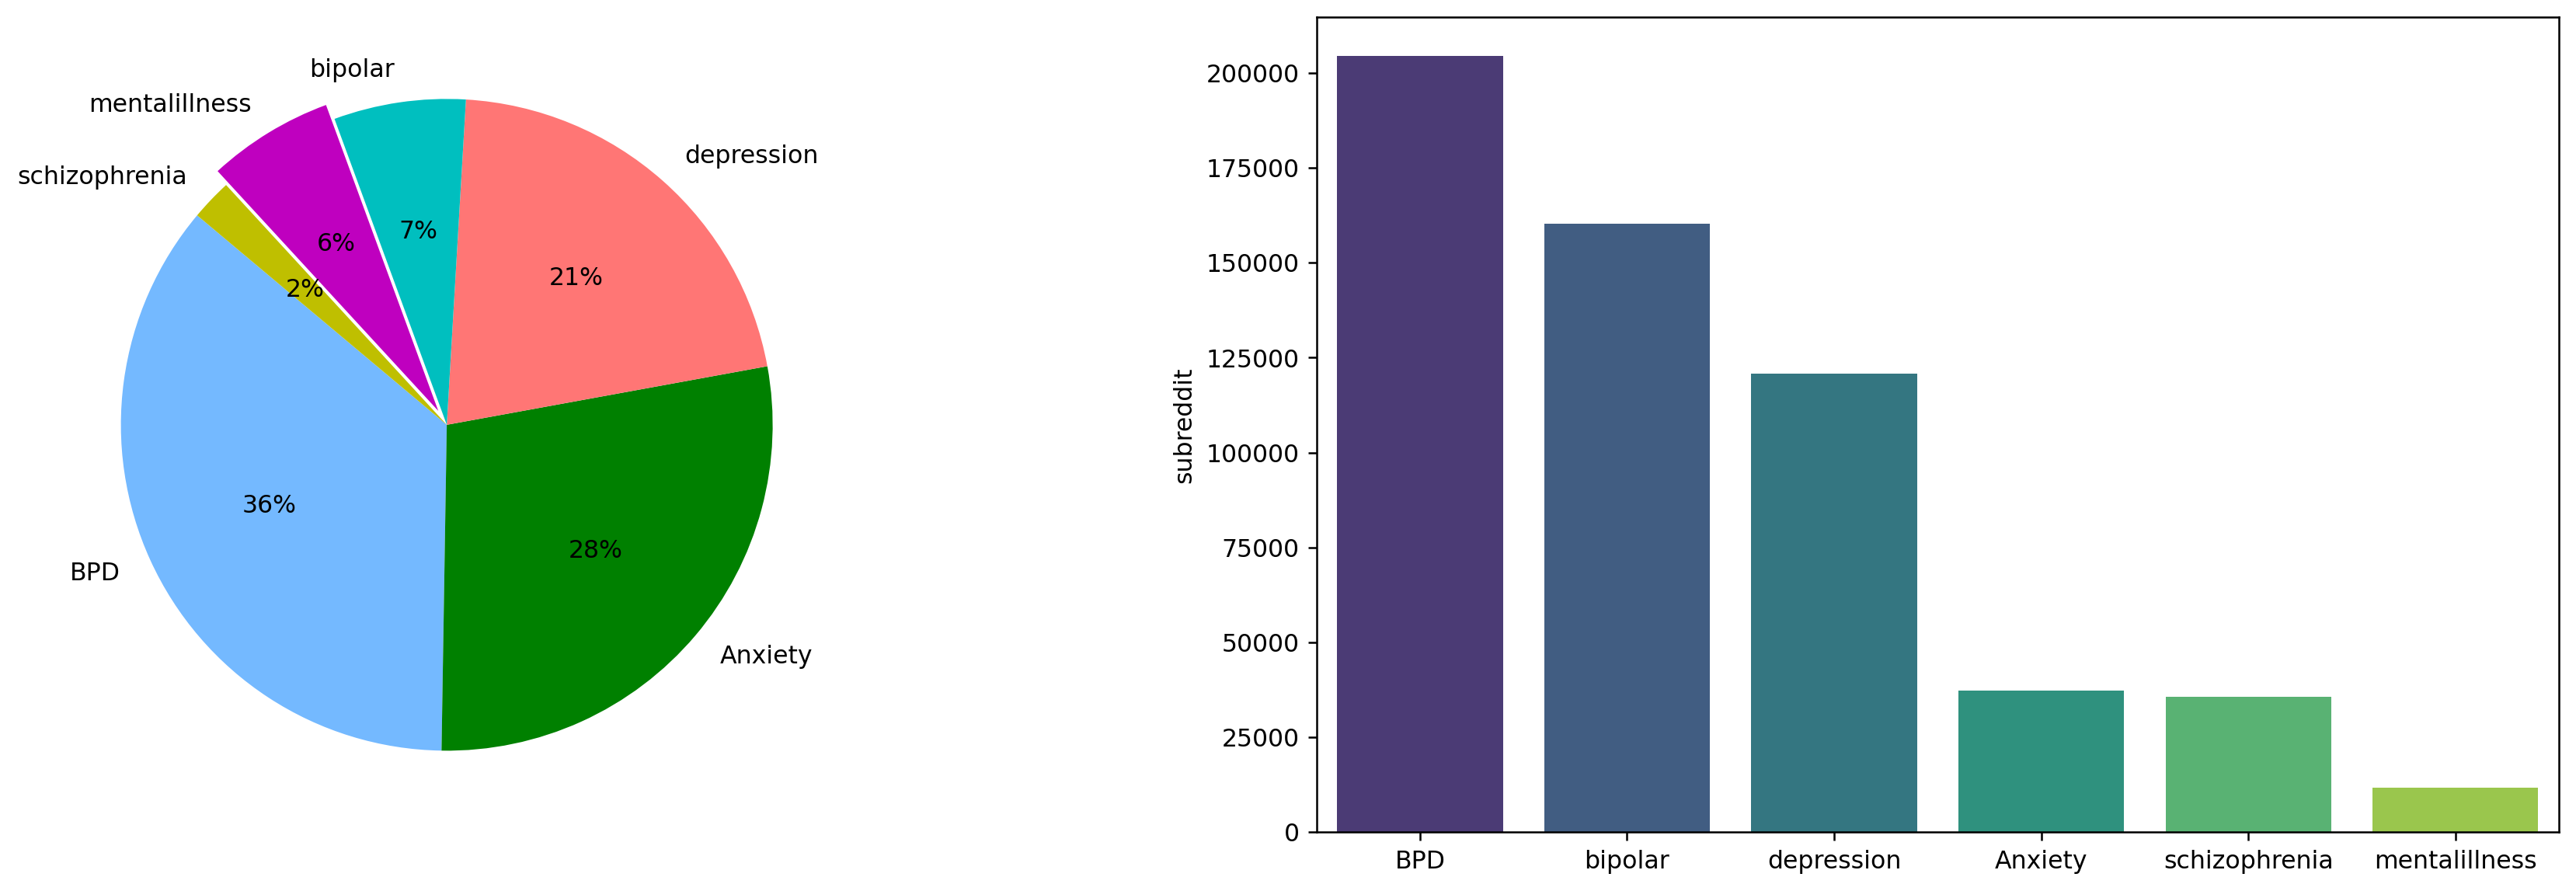

In [20]:
labels =['BPD', 'Anxiety', 'depression', 'bipolar', 'mentalillness','schizophrenia']
sizes = [204395, 160375, 120777,  37257,  35581, 11681]
custom_colours = ['#74b9ff', 'g','#ff7675','c','m','y']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 10}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0,0,0,0,0.05,0])

plt.subplot(1, 2, 2)
sns.barplot(x = df['subreddit'].unique(), y = df['subreddit'].value_counts(), palette= 'viridis')

plt.show()

BPD occupies 36%, Anxiety occupies 28% and others occupies 36%.

#### Recategorizing

In [21]:
def mental_disorders(ex):
    if ex=='BPD'or ex == 'Anxiety':
        return ex
    else:
        return 'others'

df['subreddit']=df['subreddit'].apply(mental_disorders)

In [22]:
df['subreddit'].value_counts()

others     205296
BPD        204395
Anxiety    160375
Name: subreddit, dtype: int64

<AxesSubplot:xlabel='subreddit', ylabel='count'>

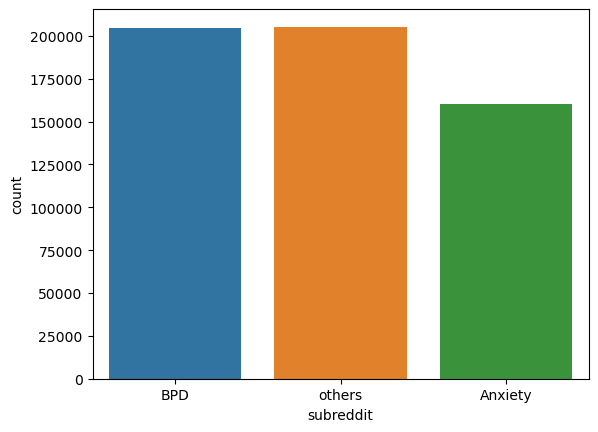

In [23]:
sns.countplot(df.subreddit)

#### Data Downsizing

In [24]:
typicalNDict = {'Anxiety':3500, 'BPD':3500, 'others':3500}

def typicalsamling(group, typicalNDict):
    name = group.name
    n = typicalNDict[name]
    return group.sample(n=n)

df_sample = df.groupby('subreddit').apply(typicalsamling, typicalNDict)

In [25]:
df_sample['subreddit'].value_counts()

Anxiety    3500
BPD        3500
others     3500
Name: subreddit, dtype: int64

<AxesSubplot:xlabel='subreddit', ylabel='count'>

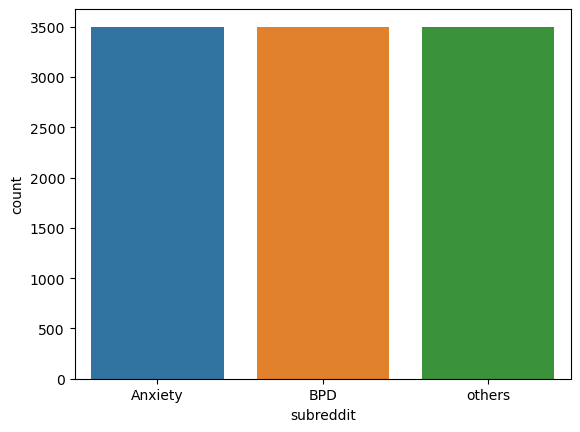

In [26]:
sns.countplot(df_sample.subreddit)

#### 'selftext' processing (Tokenization)

To prepare the text data for the model building we perform text preprocessing with removing punctuations, removing URLs, removing stop words, and lower casing, etc.

In [27]:
import re
import string

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from bs4 import BeautifulSoup

In [28]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [29]:
# Lowercasing
def convert_lowercase(text):
    text = text.lower()
    return text

df_sample['selftext'] = df_sample['selftext'].apply(convert_lowercase)

In [30]:
# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
df_sample['selftext'] = df_sample['selftext'].apply(remove_between_square_brackets)


In [31]:
# Removing URL's
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

df_sample['selftext'] = df_sample['selftext'].apply(remove_url)

In [32]:
# Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

df_sample['selftext'] = df_sample['selftext'].apply(remove_punc)

In [33]:
#Removing the stopwords from text
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

df_sample['selftext'] = df_sample['selftext'].apply(remove_stopwords)

In [34]:
# Update the number of words after tokenization
df_sample['text_total'] = df_sample['selftext'].apply(lambda x: len(x.split()))

MAX_LEN = df_sample['text_total'].max()
MAX_LEN

765

Remove entities that become empty after preprocessing. (?)

In [35]:
df_na = df_sample[df_sample['text_total'].apply(lambda x:x<=0)]

df_na.count()

title          16
selftext       16
created_utc    16
over_18        16
subreddit      16
text_total     16
text_chars     16
dtype: int64

In [36]:
df_sample = df_sample[df_sample['text_total'].apply(lambda x:x>0)]

In [37]:
le = preprocessing.LabelEncoder()
le.fit(df_sample['subreddit'])

y = le.transform(df_sample['subreddit'])
X = df_sample['selftext'].copy()

In [38]:
%%time

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = MAX_LEN # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
y_ohe = keras.utils.to_categorical(y)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 29223 unique tokens. Distilled to 29223 top words.
Shape of data tensor: (10484, 765)
Shape of label tensor: (10484, 3)
29223
CPU times: user 1.07 s, sys: 4.4 ms, total: 1.08 s
Wall time: 1.08 s


As shown above, we use fit_on_texts method to learn the dictionary of the extracted text, then word_index is the corresponding word and number mapping relationship dict, by which each word of each string can be converted to number. Then we use text_to_sequences to make up the same length by padding.

### 1.3 Evaluation Metrics

In this lab, we use F1 score as a metric to evaluate the performance of our model. The goal of our model is to classify subsections of mental disorders. We want to precisely predict the kind of text in a post, so that we can identify users who may have problems and recommend content that may be helpful. Otherwise, the recommended content would become disordered, which could upset people who do not have these troubles. Therefore, we want to make sure that both false positives and false negatives are relatively low and that the F1 score is appropriate. Since we have multiple categories in our dataset, there is no significant category imbalance, and we treat all categories equally, F1 with microscores would be better for our model evaluation.

### 1.4 Data Division

Since we have enough data entries, which is over 10k, we chose the 80/20 data split. Considering that we have enough data so that overfitting should not occur, we did not use cross-validation.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=y, 
                                                            random_state=42)

In [40]:
print('train:', y_train_ohe.shape[0]/y_ohe.shape[0])
print('test:', y_test_ohe.shape[0]/y_ohe.shape[0])

train: 0.7999809233117131
test: 0.20001907668828692


In [41]:
X_train

array([[   0,    0,    0, ...,  308,  185,  436],
       [   0,    0,    0, ...,  394,    4,  706],
       [   0,    0,    0, ..., 1951,   41, 9061],
       ...,
       [   0,    0,    0, ..., 1743,    3,    3],
       [   0,    0,    0, ...,  153, 6444,  292],
       [   0,    0,    0, ...,    7,   48,  210]], dtype=int32)

In [42]:
y_train_ohe

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## 2 Modeling

## 2.1 Train Models

In [43]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras import backend as K

NUM_CLASSES = 3

def Precision(y_true, y_pred):
    """Precision"""
    tp= K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # TP
    pp= K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = tp/ (pp + K.epsilon())
    return precision
    
def Recall(y_true, y_pred):
    """Recall"""
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    pp = K.sum(K.round(K.clip(y_true, 0, 1))) # TP + FN
    recall = tp / (pp + K.epsilon())
    return recall

def F1(y_true, y_pred):
    """F1-score"""
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1 

In [44]:
def plot(combined):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(combined['F1'])
    plt.plot(combined['val_F1'])
    plt.title('model evaluate')
    plt.ylabel('F1 score')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### 2.1.1 LSTM(Embed Size: 50, Dropout: 15%, Recurrent Dropout: 15%)

In [45]:
%%time
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.50d.txt', 'r',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = embedding_vector[:EMBED_SIZE]
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

rnn_lstm1 = Sequential()
rnn_lstm1.add(embedding_layer)
rnn_lstm1.add(LSTM(EMBED_SIZE,dropout=0.15, recurrent_dropout=0.15))
rnn_lstm1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_lstm1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[F1])

print(rnn_lstm1.summary())

Found 400000 word vectors.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 765, 50)           1461200   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 1,481,553
Trainable params: 20,353
Non-trainable params: 1,461,200
_________________________________________________________________
None
CPU times: user 3.23 s, sys: 92.7 ms, total: 3.32 s
Wall time: 3.3 s


2022-12-13 19:44:10.105670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
rnn_lstm1_history = []
tmp = rnn_lstm1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=50)
rnn_lstm1_history.append(tmp)

Epoch 1/15
168/168 [==============================] - 63s 370ms/step - loss: 1.0510 - F1: 0.4902 - val_loss: 0.9913 - val_F1: 0.5066
Epoch 2/15
168/168 [==============================] - 62s 369ms/step - loss: 0.9806 - F1: 0.5121 - val_loss: 0.9180 - val_F1: 0.5648
Epoch 3/15
168/168 [==============================] - 62s 369ms/step - loss: 0.9357 - F1: 0.5640 - val_loss: 0.9064 - val_F1: 0.5832
Epoch 4/15
168/168 [==============================] - 62s 370ms/step - loss: 0.8906 - F1: 0.5893 - val_loss: 0.8644 - val_F1: 0.5903
Epoch 5/15
168/168 [==============================] - 62s 370ms/step - loss: 0.8508 - F1: 0.6155 - val_loss: 0.8462 - val_F1: 0.6097
Epoch 6/15
168/168 [==============================] - 62s 371ms/step - loss: 0.8203 - F1: 0.6301 - val_loss: 0.7807 - val_F1: 0.6351
Epoch 7/15
168/168 [==============================] - 62s 370ms/step - loss: 0.7807 - F1: 0.6372 - val_loss: 0.8186 - val_F1: 0.6472
Epoch 8/15
168/168 [==============================] - 63s 372ms/step 

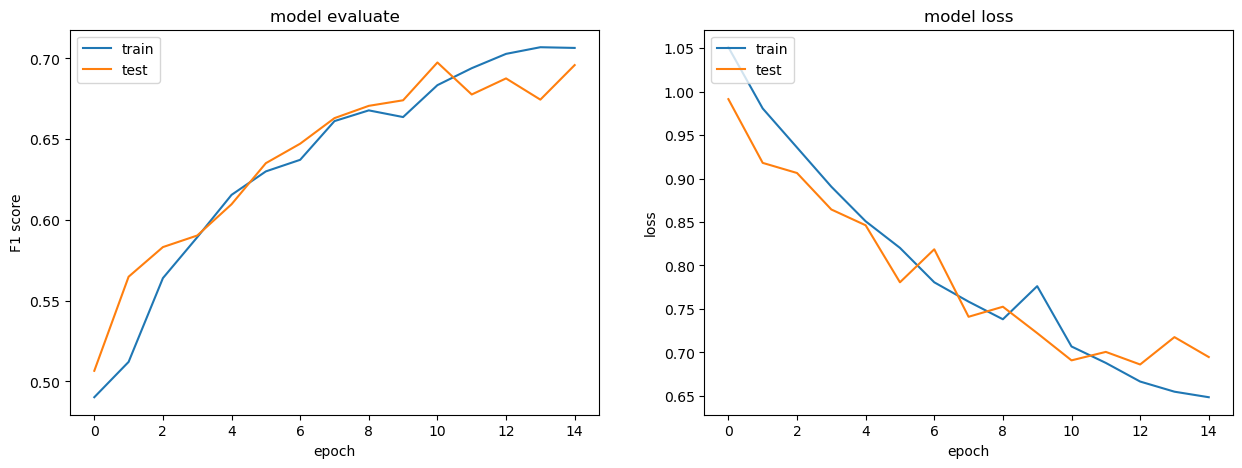

In [47]:
# combine all the history from training together
combined_lstm1 = dict()
for key in ['F1','val_F1','loss','val_loss']:
    combined_lstm1[key] = np.hstack([x.history[key] for x in rnn_lstm1_history])
plot(combined_lstm1)

### 2.1.2 LSTM(Embed Size: 50, Dropout: 30%, Recurrent Dropout: 30%)

In [48]:
%%time
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.50d.txt', 'r',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = embedding_vector[:EMBED_SIZE]
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)
rnn_lstm2 = Sequential()
rnn_lstm2.add(embedding_layer)
rnn_lstm2.add(LSTM(EMBED_SIZE,dropout=0.3, recurrent_dropout=0.3))
rnn_lstm2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_lstm2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[F1])
print(rnn_lstm2.summary())

Found 400000 word vectors.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 765, 50)           1461200   
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1,481,553
Trainable params: 20,353
Non-trainable params: 1,461,200
_________________________________________________________________
None
CPU times: user 3.25 s, sys: 43.6 ms, total: 3.29 s
Wall time: 3.28 s


In [49]:
rnn_lstm2_history = []
tmp = rnn_lstm2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=50)
rnn_lstm2_history.append(tmp)

Epoch 1/15
168/168 [==============================] - 63s 371ms/step - loss: 1.0537 - F1: 0.5075 - val_loss: 1.0438 - val_F1: 0.5419
Epoch 2/15
168/168 [==============================] - 62s 370ms/step - loss: 0.9817 - F1: 0.5512 - val_loss: 0.9865 - val_F1: 0.5506
Epoch 3/15
168/168 [==============================] - 62s 370ms/step - loss: 0.9365 - F1: 0.5792 - val_loss: 0.8923 - val_F1: 0.6135
Epoch 4/15
168/168 [==============================] - 63s 372ms/step - loss: 0.8977 - F1: 0.5985 - val_loss: 0.8235 - val_F1: 0.6306
Epoch 5/15
168/168 [==============================] - 64s 381ms/step - loss: 0.8912 - F1: 0.6075 - val_loss: 1.0020 - val_F1: 0.5439
Epoch 6/15
168/168 [==============================] - 62s 370ms/step - loss: 0.8351 - F1: 0.6338 - val_loss: 0.7929 - val_F1: 0.6449
Epoch 7/15
168/168 [==============================] - 62s 370ms/step - loss: 0.7925 - F1: 0.6485 - val_loss: 0.7586 - val_F1: 0.6761
Epoch 8/15
168/168 [==============================] - 63s 373ms/step 

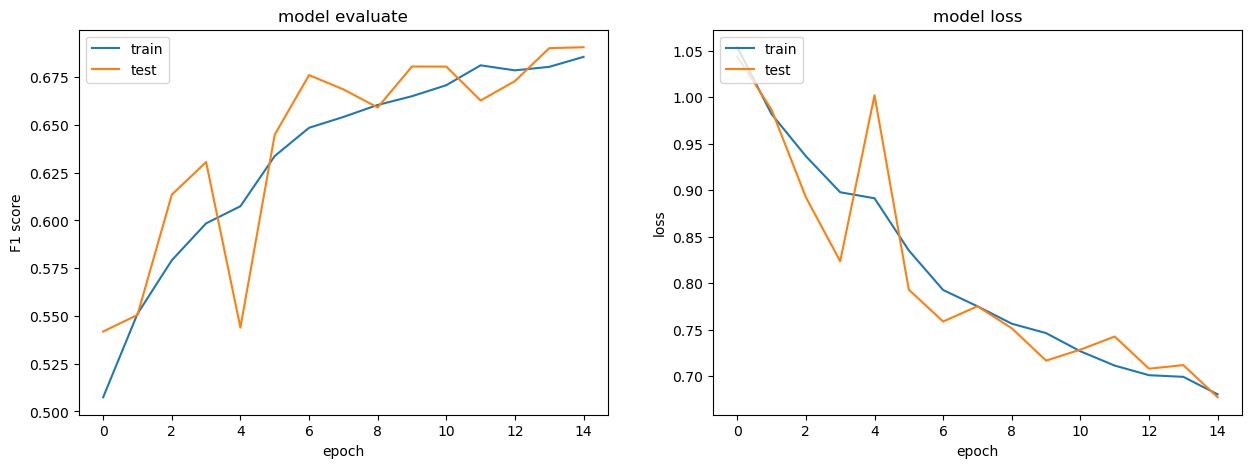

In [50]:
# combine all the history from training together
combined_lstm2 = dict()
for key in ['F1','val_F1','loss','val_loss']:
    combined_lstm2[key] = np.hstack([x.history[key] for x in rnn_lstm2_history])
    
plot(combined_lstm2)

From the result above we can compare the performance of two models using LSTM recurrent network architecture. The f1 score of model with embed size of 50, dropout 15%, and recurrent dropout 15% after 15 epochs is 0.7, and f1 score of model with embed size of 50, dropout 30%, and recurrent dropout 30% after 15 epochs is 0.68. Therefore, the model with embed size of 50, dropout 15%, and recurrent dropout 15% performs better.

### 2.1.3 GRU(Embed Size: 50, Dropout: 15%, Recurrent Dropout: 15%)

In [51]:
from tensorflow.keras.layers import GRU

EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.50d.txt', 'r',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = embedding_vector[:EMBED_SIZE]
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

rnn_gru1 = Sequential()
rnn_gru1.add(embedding_layer)
rnn_gru1.add(GRU(EMBED_SIZE,dropout=0.15, recurrent_dropout=0.15))
rnn_gru1.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[F1])

print(rnn_gru1.summary())

Found 400000 word vectors.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 765, 50)           1461200   
                                                                 
 gru (GRU)                   (None, 50)                15300     
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1,476,653
Trainable params: 15,453
Non-trainable params: 1,461,200
_________________________________________________________________
None


In [52]:
%%time
rnn_gru1_history = []
tmp = rnn_gru1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=50)
rnn_gru1_history.append(tmp)

Epoch 1/15
168/168 [==============================] - 53s 312ms/step - loss: 1.0889 - F1: 0.4444 - val_loss: 1.0516 - val_F1: 0.4909
Epoch 2/15
168/168 [==============================] - 52s 311ms/step - loss: 0.9729 - F1: 0.5357 - val_loss: 0.8710 - val_F1: 0.5776
Epoch 3/15
168/168 [==============================] - 52s 311ms/step - loss: 0.8598 - F1: 0.5907 - val_loss: 0.8845 - val_F1: 0.5846
Epoch 4/15
168/168 [==============================] - 52s 311ms/step - loss: 0.7779 - F1: 0.6237 - val_loss: 0.7309 - val_F1: 0.6618
Epoch 5/15
168/168 [==============================] - 52s 311ms/step - loss: 0.7323 - F1: 0.6585 - val_loss: 0.7111 - val_F1: 0.6683
Epoch 6/15
168/168 [==============================] - 52s 312ms/step - loss: 0.7020 - F1: 0.6724 - val_loss: 0.6749 - val_F1: 0.6874
Epoch 7/15
168/168 [==============================] - 52s 311ms/step - loss: 0.6782 - F1: 0.6811 - val_loss: 0.6634 - val_F1: 0.6882
Epoch 8/15
168/168 [==============================] - 52s 311ms/step 

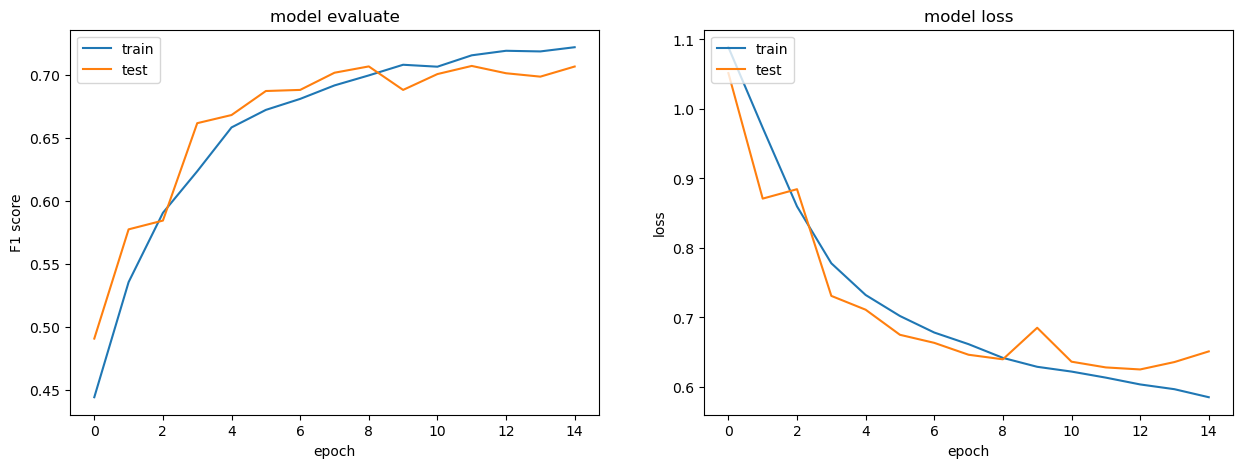

In [53]:
combined_gru1 = dict()
for key in ['F1','val_F1','loss','val_loss']:
    combined_gru1[key] = np.hstack([x.history[key] for x in rnn_gru1_history])
plot(combined_gru1)

### 2.1.4 GRU(Embed Size: 50, Dropout: 30%, Recurrent Dropout: 30%)

In [54]:
EMBED_SIZE = 50
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.50d.txt', 'r',encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_vector = embedding_vector[:EMBED_SIZE]
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

rnn_gru2 = Sequential()
rnn_gru2.add(embedding_layer)
rnn_gru2.add(GRU(EMBED_SIZE,dropout=0.3, recurrent_dropout=0.3))
rnn_gru2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[F1])

print(rnn_gru2.summary())

Found 400000 word vectors.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 765, 50)           1461200   
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 1,476,653
Trainable params: 15,453
Non-trainable params: 1,461,200
_________________________________________________________________
None


In [55]:
%%time
rnn_gru2_history = []
tmp = rnn_gru2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=15, batch_size=50)
rnn_gru2_history.append(tmp)

Epoch 1/15
168/168 [==============================] - 55s 322ms/step - loss: 1.0919 - F1: 0.4720 - val_loss: 1.0595 - val_F1: 0.5006
Epoch 2/15
168/168 [==============================] - 52s 310ms/step - loss: 1.0051 - F1: 0.5291 - val_loss: 0.8956 - val_F1: 0.5860
Epoch 3/15
168/168 [==============================] - 52s 310ms/step - loss: 0.9053 - F1: 0.5801 - val_loss: 0.8432 - val_F1: 0.6074
Epoch 4/15
168/168 [==============================] - 52s 312ms/step - loss: 0.8304 - F1: 0.6105 - val_loss: 0.7786 - val_F1: 0.6297
Epoch 5/15
168/168 [==============================] - 52s 311ms/step - loss: 0.7807 - F1: 0.6381 - val_loss: 0.7355 - val_F1: 0.6635
Epoch 6/15
168/168 [==============================] - 52s 311ms/step - loss: 0.7456 - F1: 0.6533 - val_loss: 0.7491 - val_F1: 0.6637
Epoch 7/15
168/168 [==============================] - 52s 311ms/step - loss: 0.7221 - F1: 0.6609 - val_loss: 0.7139 - val_F1: 0.6581
Epoch 8/15
168/168 [==============================] - 54s 324ms/step 

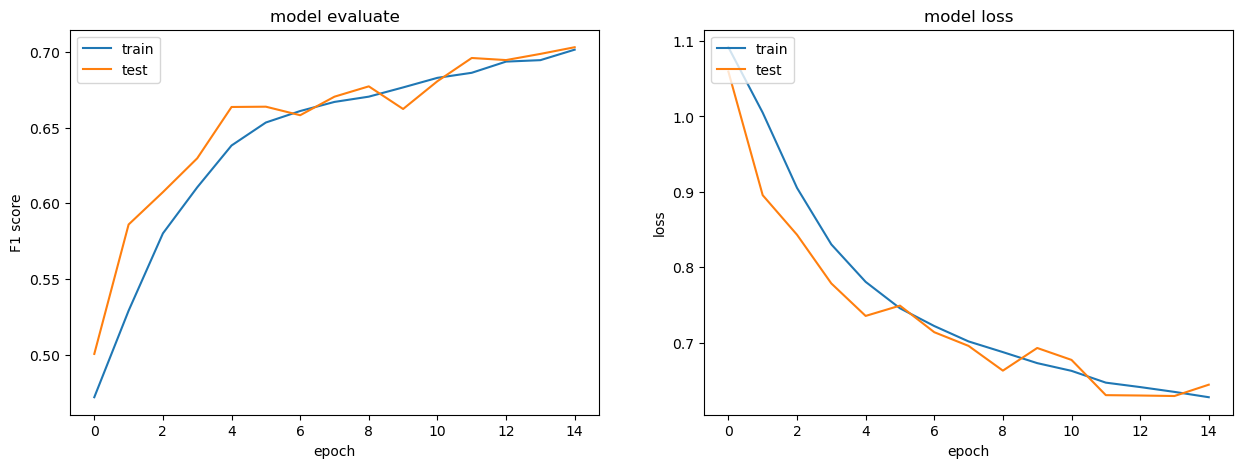

In [56]:
combined_gru2 = dict()
for key in ['F1','val_F1','loss','val_loss']:
    combined_gru2[key] = np.hstack([x.history[key] for x in rnn_gru2_history])
plot(combined_gru2)

From the result above we can compare the performance of two models using GRU recurrent network architecture. The f1 score of model with embed size of 50, dropout 15%, and recurrent dropout 15% after 15 epochs is 0.72, and f1 score of model with embed size of 50, dropout 30%, and recurrent dropout 30% after 15 epochs is 0.7. Therefore, the model with embed size of 50, dropout 15%, and recurrent dropout 15% performs better.

By comparing the result between models of LSTM architecture and models of GRU architecture, we can see that with same hyperparameter, model with GRU architecture performs better than model with LSTM architecture.

## 2.2 Statistical comparison

In [57]:
y_pred_1 = rnn_lstm1.predict(X_test)
y_pred_2 = rnn_lstm2.predict(X_test)
y_pred_3 = rnn_gru1.predict(X_test)
y_pred_4 = rnn_gru1.predict(X_test)

66/66 [==============================] - 4s 60ms/step


In [58]:
def de_ohe(y_ohe_arr):
    temp_list = []
    for tmp_arr in y_ohe_arr:
        max_idx = np.argmax(tmp_arr)
        temp_list.append(max_idx)
    y_de_ohe = np.array(temp_list)
    
    return y_de_ohe

In [59]:
y_pred_1 = de_ohe(y_pred_1)
y_pred_2 = de_ohe(y_pred_2)
y_pred_3 = de_ohe(y_pred_3)
y_pred_4 = de_ohe(y_pred_4)
y_test = de_ohe(y_test_ohe)



In [60]:
def create_contingency_McNemar(y_test, model1_pred, model2_pred):
    
    correct1_correct2 = 0  # model 1 predict correctly, model 2 also predict correctly
    correct1_wrong2 = 0 # model 1 predict correctly, model 2 predict wrong
    wrong1_correct2 = 0
    wrong1_wrong2 = 0
    table = np.zeros([2, 2],dtype = int)
    
    for i in range(len(y_test)):
        if model1_pred[i] == y_test[i] and model2_pred[i] == y_test[i]:
            correct1_correct2 +=1
        elif model1_pred[i] == y_test[i] and model2_pred[i] != y_test[i]:
            correct1_wrong2 +=1
        elif model1_pred[i] != y_test[i] and model2_pred[i] == y_test[i]:
            wrong1_correct2 +=1
        else:
            wrong1_wrong2 +=1
    table[0][0] = int(correct1_correct2)
    table[0][1] = int(correct1_wrong2)
    table[1][0] = int(wrong1_correct2)
    table[1][1] = int(wrong1_wrong2)
    
    return table

In [61]:
from statsmodels.stats.contingency_tables import mcnemar

temp_table = create_contingency_McNemar(y_test, y_pred_1, y_pred_2)
result = mcnemar(temp_table, exact=True)

print('RNN_LSTM1 & RNN_LSTM2')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')


temp_table = create_contingency_McNemar(y_test, y_pred_1, y_pred_3)
result = mcnemar(temp_table, exact=True)

print('RNN_LSTM1 & RNN_GRU1')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')


temp_table = create_contingency_McNemar(y_test, y_pred_1, y_pred_4)
result = mcnemar(temp_table, exact=True)

print('RNN_LSTM1 & RNN_GRU2')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')

temp_table = create_contingency_McNemar(y_test, y_pred_2, y_pred_3)
result = mcnemar(temp_table, exact=True)

print('RNN_LSTM2 & RNN_GRU1')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')

temp_table = create_contingency_McNemar(y_test, y_pred_2, y_pred_4)
result = mcnemar(temp_table, exact=True)

print('RNN_LSTM2 & RNN_GRU2')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')

temp_table = create_contingency_McNemar(y_test, y_pred_3, y_pred_4)
result = mcnemar(temp_table, exact=True)

print('RNN_GRU1 & RNN_GRU2')
print('contingency_tables:')
print(temp_table)
print('caculate the McNemar')
print(result)
if result.pvalue < 0.05:
    print('Reject the Null hypothesis: Different proportions of errors.')
else:
    print('Take the Null hypothesis: Same proportions of errors.')
print('---------------------------------------------------')

RNN_LSTM1 & RNN_LSTM2
contingency_tables:
[[1318  143]
 [ 148  488]]
caculate the McNemar
pvalue      0.8146586502780008
statistic   143.0
Take the Null hypothesis: Same proportions of errors.
---------------------------------------------------
RNN_LSTM1 & RNN_GRU1
contingency_tables:
[[1333  128]
 [ 170  466]]
caculate the McNemar
pvalue      0.017398894096988332
statistic   128.0
Reject the Null hypothesis: Different proportions of errors.
---------------------------------------------------
RNN_LSTM1 & RNN_GRU2
contingency_tables:
[[1333  128]
 [ 170  466]]
caculate the McNemar
pvalue      0.017398894096988332
statistic   128.0
Reject the Null hypothesis: Different proportions of errors.
---------------------------------------------------
RNN_LSTM2 & RNN_GRU1
contingency_tables:
[[1339  127]
 [ 164  467]]
caculate the McNemar
pvalue      0.03464750798202893
statistic   127.0
Reject the Null hypothesis: Different proportions of errors.
-------------------------------------------------

Based on the result of McNemar test, we can not say that the performance between model LSTM1&2( LSTM(Embed Size: 50, Dropout: 15%, Recurrent Dropout: 15%) and LSTM(Embed Size: 50, Dropout: 30%, Recurrent Dropout: 30%) ) are significantly different from each other since they all have similar proportions of errors.

Also, we can not say the model GRU1&2( GRU(Embed Size: 50, Dropout: 15%, Recurrent Dropout: 15%) and GRU(Embed Size: 50, Dropout: 30%, Recurrent Dropout: 30%) ) are significantly different from each other since they all have similar proportions of errors.

When we cross compare these model, we have confidence that we are sure these models have different proportions of errors.

| Model | F-1 score |
| ----- | --------- |
| LSTM1 | 0.7065    |
| LSTM2 | 0.6857    |
| GRU1  | 0.7221    |
| GRU2  | 0.7014    |


Therefore, we can say that the model GRU1( GRU(Embed Size: 50, Dropout: 15%, Recurrent Dropout: 15%) ) has the best performance among four models.